<img src="epfllogo.png">
<h1><center>Swiss Political Survey Dataset</center></h1>
<h4><center>By</center>
<center>Mateusz Paluchowsky</center> 
<center>Nicolas Rabany</center>
<center>Christian Tresch</center>
<center>Matthias Tsai</center></h4>

# 1. Data Collection

### 1.1. The Dataset

The dataset consists of answers to questions about political opinion collected by [smartvote](https://www.smartvote.ch). Smartvote is an organization that provides a freely accesible political opinion survey, which can be accessed and completed online. Once the questions are answered, a voting recommendation to a variety of Swiss elections can be provided according to the positions expressed by the person who took the survey. 

The dataset therefore consists of the answers from about 500'000 Swiss voters to 75 questions about political positions that could be answered with either yes, rather yes, rather no, no or no answer. The only available data about the people who took the survey is the canton in which they are elligible to vote however the political party recommendations estimated by the smartvote algorithm was also available for each of these voters. This recommendation was computed with the knowledge of the answers that different political candidates with well-defined political party affiliation had given to the same survey. The answers of about 4000 such candidates were also part of the available dataset as well as the canton they belonged to and the political party they are affiliated to. The smartvote recommendations given to voters, who had taken the survey was computed from taking the candidate with the shortest weighted euclidean distance according to their answers. This distance is defined according to the following equation:

<center>$distance(voter_i, candidate_j) = \sqrt{\sum_{k=1}^n weight_k^{(i)} \cdot (answer_k^{(i)}-answer_k^{(j)})^2}$</center>

Here the importance weights for each question were given by the voters, who answered the survey. Given these distances between all voters and all candidates, the candidate with the shortest distance can then be selected for each voter and given that these candidates are affiliated to political parties, their respective party can be recommended to the voter.

This dataset was used for the purpose of this project with the consent of smartvote under the condition that it will not be shared with third parties.

### 1.2. The Preprocessing

The preprocessing of the data consisted in selecting only the data from people who had given a definite answer to all questions, which reduced the original datasets to about 668750 samples for the voters and 3275 samples for the candidates. The next step was to quantize the qualitative answers by converting yes, rather yes, rather no and no answers to 1, 0.5, -0.5 and -1 respectively.

In [71]:
# Basic imports necessary for the Code to work

# Ipython basics
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Opensource libraries
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import sys
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
import networkx as nx

# Functions coded by us
from clean_data import *
from plot_functions import *

# Warnings are ugly
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This cell contains the code to load and preprocess the data from scratch. This is not recommended since it requires the original data files located in specific directories. The next cell contains the code to load the preprocessed data directly from a pickle file.

In [2]:
# Uncomment the following lines to load and process the data from scratch. 
# Otherwise just run the next code cell below to load the preprocessed data from a pickle file
"""
# Load and preprocess voter and candidate datasets from the raw csv files
# NOTE: This will require three csv files to be located in the correct folder (../Data/SFE2015)
#       The files are "sv_2015_recommendations_1x.csv", "smartvote_C_2015_V2.0.csv" and "candidate_parties.csv"
data,parties = get_voter_data()
candidates = get_candidate_data()
"""

'\n# Load and preprocess voter and candidate datasets from the raw csv files\n# NOTE: This will require three csv files to be located in the correct folder (../Data/SFE2015)\n#       The files are "sv_2015_recommendations_1x.csv", "smartvote_C_2015_V2.0.csv" and "candidate_parties.csv"\ndata,parties = get_voter_data()\ncandidates = get_candidate_data()\n'

The cell below allows to load the data from a pickle file containing the preprocessed data.
It is important that the mentioned pickle file is located in the same directory as this notebook.

In [3]:
# Load the prepocessed data from a pickle file.
# NOTE: The file "clean_data.pkl" should be located in the same directory as this notebook!
with open(r"clean_data.pkl", "rb") as input_file:
    (data, candidates, parties) = pickle.load(input_file)

In [4]:
# Sets new indices to the voter and candidate datasets to avoid missing indexes due to the removed samples
data.reset_index(inplace=True)
data.drop(['index'], axis=1, inplace=True)
candidates.reset_index(inplace=True)
candidates.drop(['index'], axis=1, inplace=True)

# 2. Data Exploration

### 2.1. Descriptive Statistics
In order to analyze, if the data is representative of the Swiss population, different demgraphic distributions were plotted. First, the geographic distribution of the voters and candidates, who answered the survey was plotted according to their respective cantons. Second, since age and gender was only know for the candidates, this distribution was only plotted for the candidate data.

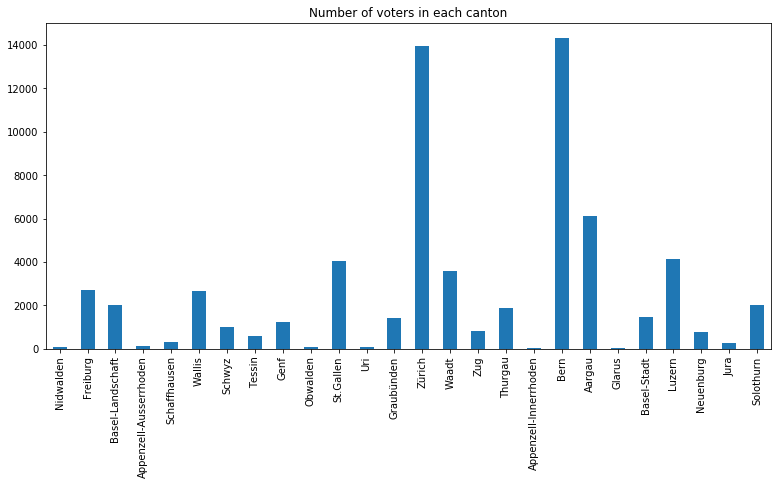

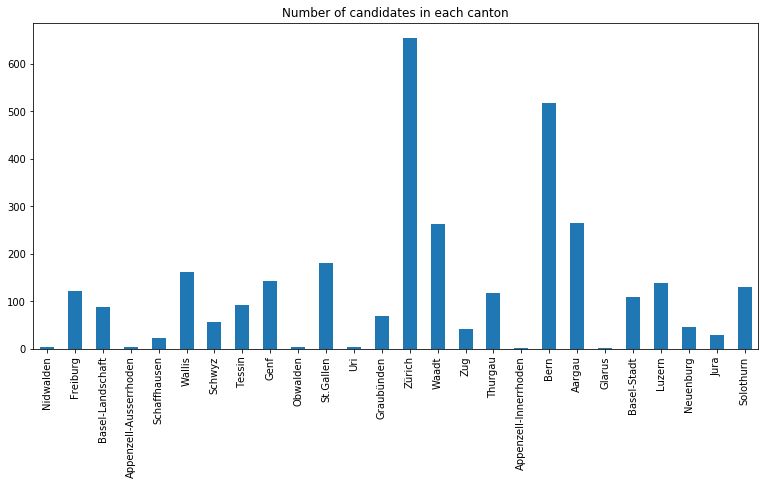

In [5]:
# Plotting the geographic distribution of the voters and the candidates who answered the survey

# Grouping by Canton
cantons = ['Aargau', 'Appenzell-Ausserrhoden', 'Appenzell-Innerrhoden', 'Basel-Landschaft', 'Basel-Stadt', 'Bern',
           'Freiburg', 'Genf', 'Glarus', 'Graubünden', 'Jura', 'Luzern', 'Neuenburg', 'Nidwalden', 'Obwalden',
           'Schaffhausen', 'Schwyz', 'Solothurn', 'St.Gallen', 'Tessin', 'Thurgau', 'Uri', 'Waadt', 'Wallis', 
           'Zürich', 'Zug']
voters_count_per_canton = data.groupby(['sv_canton']).count()['recommendation'].tolist()
candidates_count_per_canton = candidates.groupby(['ID_district']).count()['party_REC'].tolist()

# For the Voter dataset
voters_canton = pd.DataFrame.from_dict(dict(zip(cantons, voters_count_per_canton)), orient='index')
voters_canton.plot(kind='bar', legend=False, figsize=(13,6),)
plt.title('Number of voters in each canton')
plt.show()

# For the Candiate datset
candidates_canton = pd.DataFrame.from_dict(dict(zip(cantons, candidates_count_per_canton)), orient='index')
candidates_canton.plot(kind='bar', legend=False, figsize=(13,6),)
plt.title('Number of candidates in each canton')
plt.show()

One can observe that the distributions of voters and candidates are almost exactly the same (taking their relative percentage of occurence by canton into account), where cantons with higher amount of voters are represented by higher amount of candidates. These distributions also reflect the relative distribution of the Swiss population by canton with Zürich, Bern, Aargau and Waadt being the most populated and Appenzell_Innerrhoden, Uri, Obwalden, Glarus, Nidwalden and Appenzell-Ausserrhoden as the lest populated cantons.

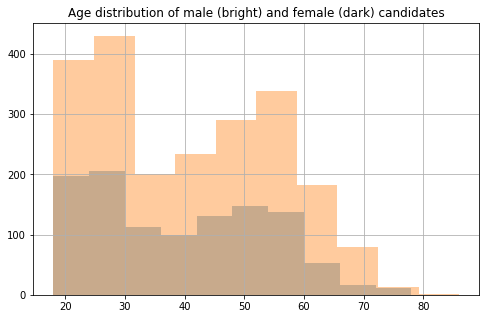

In [6]:
# Plotting the age and gender distribution of the candidates
ax = candidates.groupby('gender').age.hist(alpha=0.4, figsize=(8,5))
plt.title('Age distribution of male (bright) and female (dark) candidates')
plt.show()

The age distribution histogram above shows that there is aproximately 50% of female and 50% of male candidates in most age groups. The only exception being for the older age groups, where males seem to be predominant. The relatively high number of young people is slightly surprising and it could be explained by the hypothesis that younger candidates were more likely to take the smartvote online survey than older more established politicians. This could thus be an indication that the candidate dataset could be biased towards younger candidates.

## 2.2 Party related histogram comparison 

Each bin of the following histograms corresponds to the parties extracted and combined in the following list:

In [7]:
[(i, p) for i,p in enumerate(parties)]

[(0, 'AL'),
 (1, 'BDP'),
 (2, 'JBDP'),
 (3, 'CSP'),
 (4, 'CVP'),
 (5, 'JCVP'),
 (6, 'EDU'),
 (7, 'EVP'),
 (8, 'jevp'),
 (9, 'FDP'),
 (10, 'jf'),
 (11, 'glp'),
 (12, 'jglp'),
 (13, 'GPS'),
 (14, 'JGPS'),
 (15, 'SVP'),
 (16, 'JSVP'),
 (17, 'SP'),
 (18, 'JUSO'),
 (19, 'Lega'),
 (20, 'MCG'),
 (21, 'Parteilos'),
 (22, 'PdA'),
 (23, 'Piraten'),
 (24, 'Others')]

The first histograms is showing how many voters got which party recommendation by smartvote.

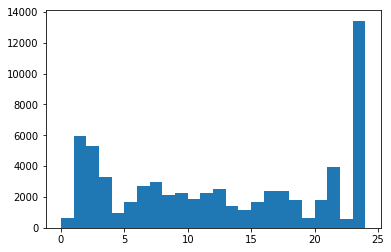

In [8]:
plt.hist(data['recommendation'], 24)
plt.show()

The second histogram shows how many candidates actually filled the survey from each party

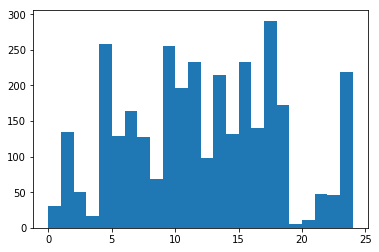

In [9]:
plt.hist(candidates['party_REC'], 24)
plt.show()

An interesting result we have found from these two histograms was that the party 'CVP' (bin number 4) has many candidates that have filled the questionnaire and took part in exposing their online profile to potiential voters, but only very few of them have succeeded in getting recommendations to voters as seen in the first histogram.

# 3. Data Exploitation

## 3.1. Graph Exploitation

### 3.1.1 Compute party recommendation

In this section, a recommended party has been assigned to every voters. This party corresponds to the party of the candidate who had the most similarities in the way of answering the surey. The similarity between a voter and a candidate has been calculated by doing the cosinus distance between all the answers of the voter and the candidate. The smallest distance indicates the most similar candidate.

### 3.1.1 Compute party recommendation

In this section, a recommended party has been assigned to every voters. This party corresponds to the party of the candidate who had the most similarities in the way of answering the surey. The similarity between a voter and a candidate has been calculated by doing the cosinus distance between all the answers of the voter and the candidate. The smallest distance indicates the most similar candidate.

In [10]:
# Extract the 'answers' columns form the dataset for every voters
answer_columns = [n for n in data.columns if 'answer_' in n] 

# Compute the distance between voters and candidates
voter_candidate_distance = scipy.spatial.distance.cdist(data[answer_columns], candidates[answer_columns], 'cosine')

# Chose the best candidate
voter_best_candidate = voter_candidate_distance.argmin(axis=1)

# Extract the corresponding parties of each best candidates
voter_best_party = [int(candidates.loc[best_can]['party_REC']) for best_can in voter_best_candidate]

# Assign these parties to the voters
data['our_recommendation'] = voter_best_party

#### Comparison with the recommendation computed by www.smartvote.ch

https://www.smartvote.ch/ also did a party recommendation and here we compared our results to theirs.

In [11]:
(data['recommendation'] == data['our_recommendation']).value_counts()

False    48013
True     17862
dtype: int64

We count 1/3 of matching parties only. It is quite a mismatch that we have between our results, but we have no means of saying if their recommendation is accurate or not. However, the voters had the possibility to weight their answers and to give more importance to some questions than others. In our party recommendation we didn't take the weights in account and that is maybe the source of the mismatch. 

### 3.1.2 Feature extraction

##### Voters

Here for the voter dataset, we compute the centroids of:
1. The party recommendations from https://www.smartvote.ch/.
2. Our party recommendations.
3. The cantons.

In [12]:
# Compute centroids of the www.smartvote.ch recommendations
party_centroids = data.drop(['sv_canton', 'our_recommendation'], axis=1).groupby(['recommendation']).mean()
# Compute centroids of our recommendations
party_our_centroids = data.drop(['sv_canton', 'recommendation'], axis=1).groupby(['our_recommendation']).mean()
# Compute centroids of the cantons
canton_centroids = data.drop(['recommendation', 'our_recommendation'], axis=1).groupby(['sv_canton']).mean()

##### Candidates

Here for the candidate dataset, we compute the centroids of:
1. The parties of the candidates.
2. The cantons.
We drop the irrelevant data for our project like age, gender..

In [13]:
# Compute centroids for the candidate parties
can_party_centroids = candidates.drop(['ID_district', 'gender', 'age', 'age_REC', 'age_REC2'], axis=1).groupby(['party_REC']).mean()
# Compute centroids for the cantons
can_canton_centroids = candidates.drop(['party_REC', 'gender', 'age', 'age_REC', 'age_REC2'], axis=1).groupby(['ID_district']).mean()

##### Voters and candidates combined

Here for the voter dataset, we compute the centroids of:
1. The party recommendations of the voters from https://www.smartvote.ch/ combined to the parties of the candidates.
2. Our party recommendations of the voters combined to the parties of the candidates.

In [14]:
# Based on https://www.smartvote.ch/ recommendations
party_centroids_new = party_centroids.reset_index()
party_centroids_new['REC'] = party_centroids_new['recommendation'].apply(lambda x: str(x) + '_party' )
party_centroids_new.drop(['recommendation'], axis=1, inplace=True)

can_party_centroids_new = can_party_centroids.reset_index()
can_party_centroids_new['REC'] = can_party_centroids_new['party_REC'].apply(lambda x: str(x) + '_can_party' )
can_party_centroids_new.drop(['party_REC'], axis=1, inplace=True)

frames = [party_centroids_new, can_party_centroids_new]

party_and_candidates_centroids = pd.concat(frames)
party_and_candidates_centroids.set_index(['REC'], inplace=True)

In [15]:
# Based on our recommendations
party_our_centroids_new = party_our_centroids.reset_index()
party_our_centroids_new['REC'] = party_our_centroids_new['our_recommendation'].apply(lambda x: str(x) + '_party' )
party_our_centroids_new.drop(['our_recommendation'], axis=1, inplace=True)

frames = [party_our_centroids_new, can_party_centroids_new]

party_our_and_candidates_centroids = pd.concat(frames)
party_our_and_candidates_centroids.set_index(['REC'], inplace=True)

In [16]:
# Compute centroids for the parties
party_and_can_dist_array = scipy.spatial.distance.pdist(party_and_candidates_centroids, metric='cosine')
party_our_and_can_dist_array = scipy.spatial.distance.pdist(party_and_candidates_centroids, metric='cosine')
# Compute centroids for the cantons
party_and_can_distances = scipy.spatial.distance.squareform(party_and_can_dist_array)
party_our_and_can_distances = scipy.spatial.distance.squareform(party_and_can_dist_array)

### 3.1.3 Graph construction

#### 3.1.3.1 Distances

We decided to compute the cosinus distance as it is a good choice for high-dimensional data. It is defined as follow:
$$d(u,v) = 1 - \frac{u \cdot v} {\|u\|_2 \|v\|_2}$$

##### Voters

We computed the distance over the centroids for the 3 cases:
1. The party recommendations from https://www.smartvote.ch/.
2. Our party recommendations.
3. The cantons.

Text(0.5,1,'Cantons')

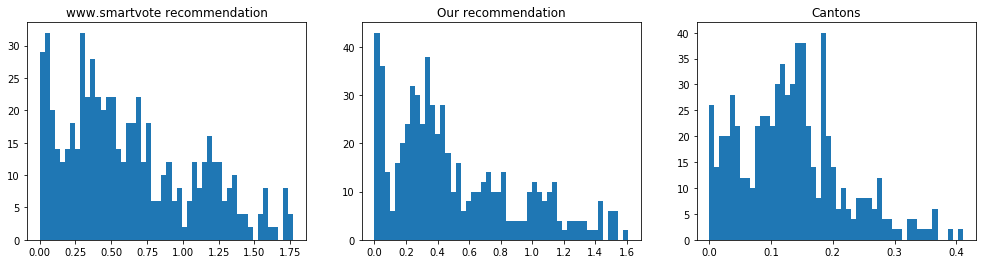

In [17]:
# Compute the cosinus distances
party_dist_array = scipy.spatial.distance.pdist(party_centroids, metric='cosine')
party_our_dist_array = scipy.spatial.distance.pdist(party_our_centroids, metric='cosine')
canton_dist_array = scipy.spatial.distance.pdist(canton_centroids, metric='cosine')

# Convert the array to a square matrix
party_distances = scipy.spatial.distance.squareform(party_dist_array)
party_our_distances = scipy.spatial.distance.squareform(party_our_dist_array)
canton_distances = scipy.spatial.distance.squareform(canton_dist_array)

# Plot
fix, axes = plt.subplots(1, 3, figsize=(17, 4))
axes[0].hist(party_distances.reshape(-1), bins=50); #reshape to flatten
axes[0].set_title('www.smartvote recommendation')
axes[1].hist(party_our_distances.reshape(-1), bins=50); 
axes[1].set_title('Our recommendation')
axes[2].hist(canton_distances.reshape(-1), bins=50); 
axes[2].set_title('Cantons')


##### Candidates

We computed the distance over the centroids for the 3 cases:
1. The parties of the candidates.
3. The cantons.

We don't plot the distributioin here.

In [18]:
# Compute the cosinus distances
can_party_dist_array = scipy.spatial.distance.pdist(can_party_centroids, metric='cosine')
can_canton_dist_array = scipy.spatial.distance.pdist(can_canton_centroids, metric='cosine')

# Convert the array to a square matrix
can_party_distances = scipy.spatial.distance.squareform(can_party_dist_array)
can_canton_distances = scipy.spatial.distance.squareform(can_canton_dist_array)

##### Voters and candidates

We computed the distance over the centroids for the 3 cases:
1. The parties of the candidates and party recommendations of the voters (www.smartvote.ch).
3. The parties of the candidates and our party recommendations of the voters.

We don't plot the distributioin here.

In [19]:
# Compute the cosinus distances
party_and_can_dist_array = scipy.spatial.distance.pdist(party_and_candidates_centroids, metric='cosine')
party_our_and_can_dist_array = scipy.spatial.distance.pdist(party_our_and_candidates_centroids, metric='cosine')

# Convert the array to a square matrix
party_and_can_distances = scipy.spatial.distance.squareform(party_and_can_dist_array)
party_our_and_can_distances = scipy.spatial.distance.squareform(party_our_and_can_dist_array)

#### 3.1.3.2 Weighted adjacency matrix

From our distance we compute edge weights. We use the Gaussian kernel to do that. The more similar are the centroids, the stronger are the edges. The weight matrix is computed as:
$$\mathbf{W}(u,v) = \exp \left( \frac{-d^2(u, v)}{\sigma^2} \right)$$
We used the mean of the centroids as kernel width.

##### Voters

In [20]:
# Compute the kernel width
kernel_width = party_distances.mean()
kernel_width2 = party_our_distances.mean()
kernel_width3 = canton_distances.mean()

# Compute the weight matrix
party_weights = np.exp(-party_distances**2/kernel_width**2)
party_our_weights = np.exp(-party_our_distances**2/kernel_width2**2)
canton_weights = np.exp(-canton_distances**2/kernel_width3**2)

# Set the diagonal to zero to avoid self connections
np.fill_diagonal(party_weights, 0)
np.fill_diagonal(party_our_weights, 0)
np.fill_diagonal(canton_weights, 0)

##### Candidates

In [21]:
# Compute the kernel width
kernel_width = can_party_distances.mean()
kernel_width2 = can_canton_distances.mean()

# Compute the weight matrix
can_party_weights = np.exp(-can_party_distances**2/kernel_width**2)
can_canton_weights = np.exp(-can_canton_distances**2/kernel_width2**2)

# Set the diagonal to zero to avoid self connections
np.fill_diagonal(can_party_weights, 0)
np.fill_diagonal(can_canton_weights, 0)

##### Voters and candidates

In [22]:
# Compute the kernel width
kernel_width = party_and_can_distances.mean()
kernel_width2 = party_our_and_can_distances.mean()

# Compute the weight matrix
party_and_can_weights = np.exp(-party_and_can_distances**2/kernel_width**2)
party_our_and_can_weights = np.exp(-party_our_and_can_distances**2/kernel_width2**2)

# Set the diagonal to zero to avoid self connections
np.fill_diagonal(party_and_can_weights, 0)
np.fill_diagonal(party_our_and_can_weights, 0)

#### 3.1.3.3 Pruning/Thresholding

In 4.1, we created a fully connected graph but we want to sparsify it so that it becomes more interesting to analyse. We did it by keeping the 5 strongest edges for each node. We plot the weight matrix and its distribution only for the first case of the voters: www.smartvote.ch party centroids. There are 2 plots: before and after the prunning. The result for the 2 other cases are similar.

In [23]:
NEIGHBORS = 5

# The plot function is used to plot the weight matrix and its distribution
def plot(weights, axes):
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50);

##### Voters

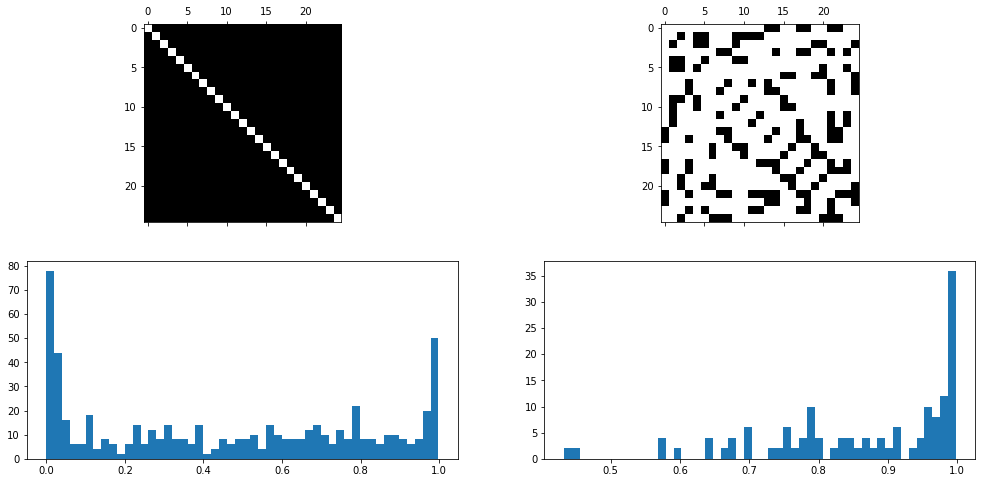

In [24]:
fix, axes = plt.subplots(2, 2, figsize=(17, 8))
plot(party_weights, axes[:, 0])

# Filter k-strongest neighbors
for row in party_weights:
    idxs = np.argsort(row)
    idxs = idxs[:-NEIGHBORS]
    row[idxs]=0

for row in party_our_weights:
    idxs = np.argsort(row)
    idxs = idxs[:-NEIGHBORS]
    row[idxs]=0
    
for row in canton_weights:
    idxs = np.argsort(row)
    idxs = idxs[:-NEIGHBORS]
    row[idxs]=0
    
# Assure symmetricity
weights = np.maximum(party_weights, party_weights.transpose())
weights_our = np.maximum(party_our_weights, party_our_weights.transpose())
canton_weights = np.maximum(canton_weights, canton_weights.transpose())

plot(weights, axes[:, 1])

##### Candidates

In [25]:
# Filter k-strongest neighbors
for row in can_party_weights:
    idxs = np.argsort(row)
    idxs = idxs[:-NEIGHBORS]
    row[idxs]=0
    
for row in can_canton_weights:
    idxs = np.argsort(row)
    idxs = idxs[:-NEIGHBORS]
    row[idxs]=0
    
# Assure symmetricity
can_weights = np.maximum(can_party_weights, can_party_weights.transpose())
can_canton_weights = np.maximum(can_canton_weights, can_canton_weights.transpose())

##### Voters and candidates

In [26]:
# Filter k-strongest neighbors
for row in party_and_can_weights:
    idxs = np.argsort(row)
    idxs = idxs[:-NEIGHBORS]
    row[idxs]=0

for row in party_our_and_can_weights:
    idxs = np.argsort(row)
    idxs = idxs[:-NEIGHBORS]
    row[idxs]=0
    
    
# Assure symmetricity
weights_and_can = np.maximum(party_and_can_weights, party_and_can_weights.transpose())
weights_our_and_can = np.maximum(party_our_and_can_weights, party_our_and_can_weights.transpose())

### 3.1.4 Visualization

We can now visualize the graph by using the networkx library. It shows how similar are the centroids and the links between the most similar of them.

#### 3.1.4.1 Parties

First we construct the party labels and then we group them in 4 categories according to 2010-14 diagram from Solomon/UZH/Tagesanzeiger April 2014. And a different color has be assigned to each group.
* Left-Liberal (red)
* Left-Conservative (yellow)
* Right-Liberal (blue)
* Right-Conservative (green)

The edges between parties and the corresponding younger parties (e.g. GPS and JGPS) will also be colored with the same color used for the nodes. Three graphs are showed in this section corresponding to centroids of the party recommendation (from https://www.smartvote.ch/ and ours) of the voters and the parties of the candidates

Text(0.5,1,'Party Graph from candidates')

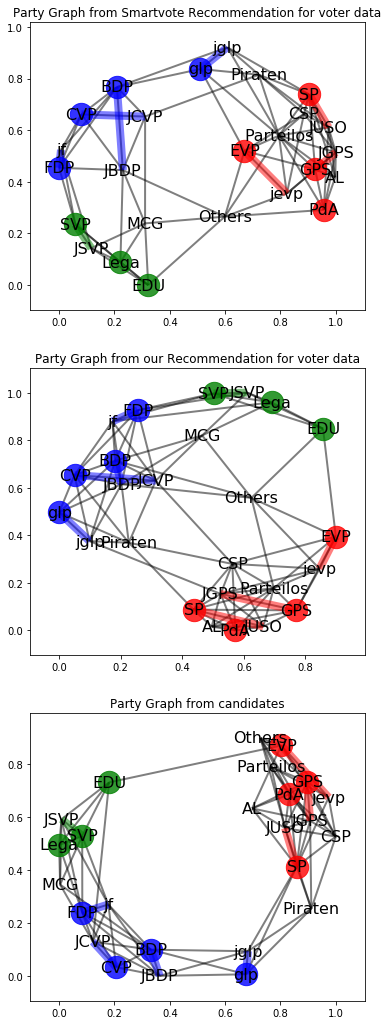

In [27]:
# Construct party labels
party_labels = dict(enumerate(parties))

# Plot Party Graphs for candidates and for voters with Smartvote or our recommendation
fix, axes = plt.subplots(3, 1, figsize=(6, 18))
plot_party_graph(party_weights, party_labels, axes[0])
axes[0].set_title("Party Graph from Smartvote Recommendation for voter data")
plot_party_graph(party_our_weights, party_labels, axes[1])
axes[1].set_title("Party Graph from our Recommendation for voter data")
plot_party_graph(can_party_weights, party_labels, axes[2])
axes[2].set_title("Party Graph from candidates")

#### 3.1.4.2 Cantons

For the cantons, first we construct the canton labels and then we group them in 3 categories corresponding to the language spoken in those cantons. A different color has been assigned to each group.
* French part (red)
* German part (blue)
* Italian part (green)

Two graphs are showed in this section corresponding to centroids of the cantons of the voters and candidates.

Text(0.5,1,'Canton Graph from candidate data')

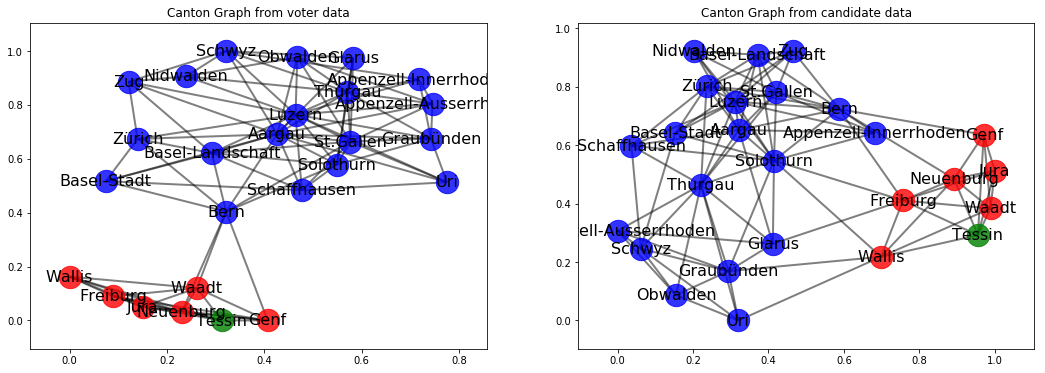

In [28]:
# Contruct canton labels
cantons = ['Aargau','Appenzell-Ausserrhoden','Appenzell-Innerrhoden','Basel-Landschaft','Basel-Stadt','Bern','Freiburg','Genf','Glarus','Graubünden','Jura','Luzern','Neuenburg','Nidwalden','Obwalden','Schaffhausen','Schwyz','Solothurn','St.Gallen','Tessin','Thurgau','Uri','Waadt','Wallis','Zürich','Zug']
canton_labels = dict(enumerate(cantons))


fix, axes = plt.subplots(1, 2, figsize=(18, 6))
plot_canton_graph(canton_weights, canton_labels, axes[0])
axes[0].set_title("Canton Graph from voter data")
plot_canton_graph(can_canton_weights, canton_labels, axes[1])
axes[1].set_title("Canton Graph from candidate data")

#### 3.1.4.3 Parties for voters and candidates

Text(0.5,1,'Party Graph from candidate data and voter data based on our recommendation')

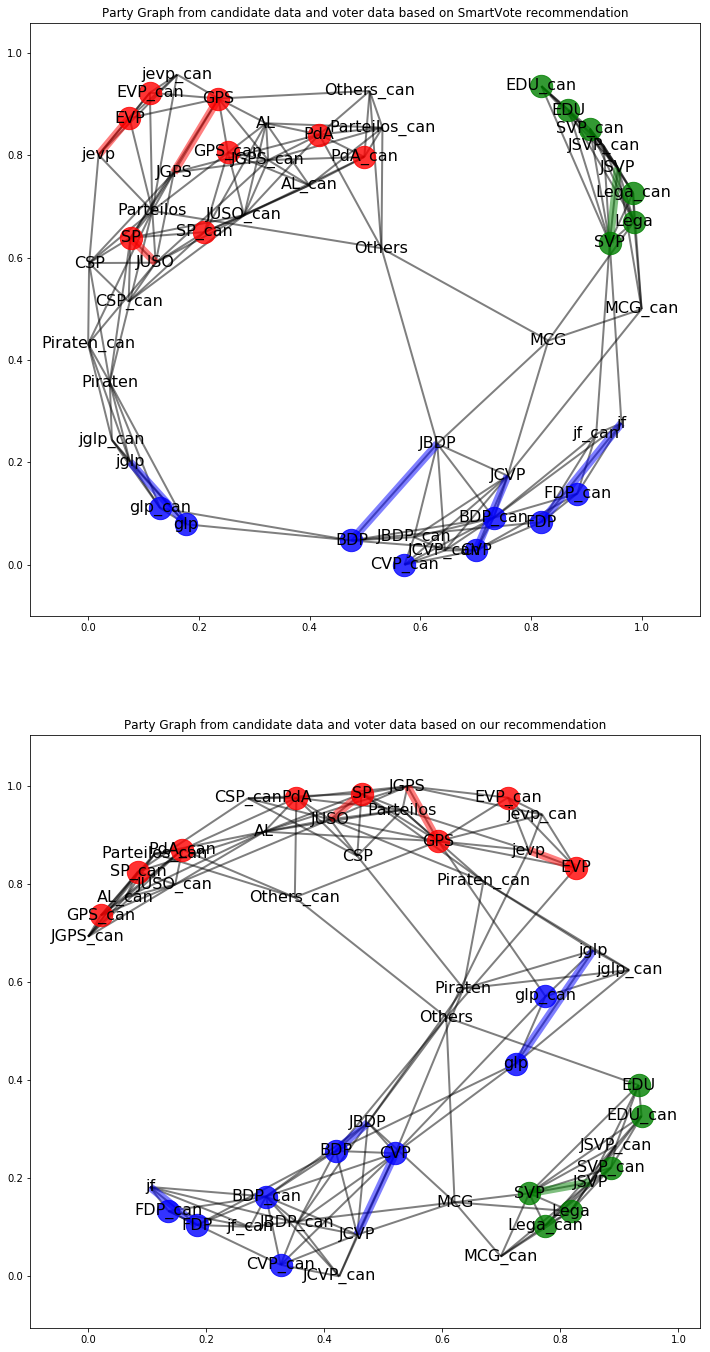

In [29]:
# Construct party labels
party_labels = parties
party_and_can_labels = {}
for i, l in enumerate(party_labels):
    party_and_can_labels[int(i)] = l
    party_and_can_labels[int(i) + 25] = l + '_can'
    
#
fix, axes = plt.subplots(2,1, figsize=(12, 24))
plot_party_graph_voter_and_candidate(weights_and_can, party_and_can_labels, axes[0])
axes[0].set_title("Party Graph from candidate data and voter data based on SmartVote recommendation")
plot_party_graph_voter_and_candidate(weights_our_and_can, party_and_can_labels, axes[1])
axes[1].set_title("Party Graph from candidate data and voter data based on our recommendation")

In [30]:
neighbor_counter = 0
nb_labels = int(len(weights_and_can)/2)

for i in range(nb_labels):
   if weights_and_can[i,i+nb_labels]>0.5:
       neighbor_counter += 1

direct_neighbor_ratio = neighbor_counter/nb_labels
       
print("Number of connected centroids that should be identical is ", neighbor_counter, " out of 25 for the smartvote recommendation")
print("Ratio of connected centroids that should be identical is ", int(direct_neighbor_ratio*100),'% for the smartvote recommendation')

neighbor_counter = 0
nb_labels = int(len(weights_our_and_can)/2)

for i in range(nb_labels):
   if weights_and_can[i,i+nb_labels]>0.5:
       neighbor_counter += 1

direct_neighbor_ratio = neighbor_counter/nb_labels
       
print("Number of connected centroids that should be identical is ", neighbor_counter, " out of 25 for our recommendation")
print("Ratio of connected centroids that should be identical is ", int(direct_neighbor_ratio*100),'% for our recommendation')

Number of connected centroids that should be identical is  24  out of 25 for the smartvote recommendation
Ratio of connected centroids that should be identical is  96 % for the smartvote recommendation
Number of connected centroids that should be identical is  24  out of 25 for our recommendation
Ratio of connected centroids that should be identical is  96 % for our recommendation


Observations:
- As expected, from the voters and candidates graph we can clearly distinguish the seperation between three main political fractions - left wing, right conservative wing and right liberal wing (Depicted respectively by red, green and blue) as in the diagram (from [wikipedia](https://en.wikipedia.org/wiki/List_of_political_parties_in_Switzerland)) below.
- The stereotypical thinking such that French part is more leftist, while German part of Switzerland is more conservative seems to hold when looking at cantonal representation of the graph. The Röstigraben is clearly visible.
- Joint graph for voters and candidates indicate how closely the voters recommendations are in comparison with known candidates. Since we are working with centroids, a perfect match (thus no distance between voters party and candidate party nodes) is impossible. Luckily we achieve a high match of 24 out of 25 voters parties being matched with their candidate party counterpart.
- Joint graph performed on voters with our recomendation seems to achieve better results in terms of smaller distances between 'mother' parties and 'junior' sections of the same party, which make sense since we would expect the political opinion of the two to be aligned.

<img src="swiss_parties.png" width=500>

## 3.2 Dimensionality reduction using PCA

In order to be able to compare the above calculated centroids of either dataset within the multidimensional space of survey answers we decided to further exploit the data this time embedded in a comparable coordinate system. Therefore we decided to use PCA to reduce the dimensionality of the data and visualize it in two dimensions. This had the advantage of being able to process the bigger voter dataset without having to calculate an adjacency matrix of the size 65'875^2. Both processes were done always for the candidate and the voter dataset.

### 3.2.1 PCA candidates

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn import preprocessing, decomposition

Cleaned up candidate answers and corresponding labels were generated.

In [32]:
can_answers = candidates.drop(['party_REC', 'ID_district', 'gender', 'age', 'age_REC', 'age_REC2'], axis=1)
can_labels_true = candidates['party_REC']

Subsequently the actual PCA is performed on the candidate dataset

In [33]:
candidate_pca = decomposition.PCA().fit(can_answers)
candidate_features_pca = candidate_pca.transform(can_answers)
can_party_label = preprocessing.LabelEncoder().fit_transform(can_labels_true)

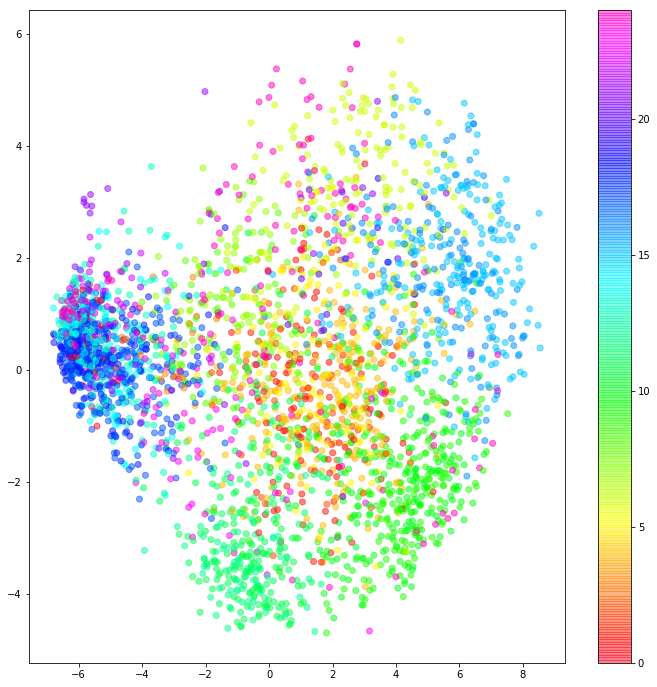

In [34]:
plt.figure(3,figsize=(12,12)) 
plt.scatter(candidate_features_pca[:, 0], candidate_features_pca[:, 1], c=can_party_label, cmap='gist_rainbow', alpha=0.5);
plt.colorbar()
plt.show()

We can see a more or less clear but not perfect separation of the parties in the PCA space. It should be noted that the purple points that seem to be dispersed rather widely within the data points correspond the the party group 'others' hence it is expected that these points don't clearly belong to a party.

### 3.2.1 PCA voters

We have then done the same PCA procedure with the considerably bigger voter dataset

In [35]:
voters = data.drop(['sv_canton', 'recommendation', 'our_recommendation'], axis=1)
voter_labels_true = data['recommendation']

In [36]:
voters_pca = decomposition.PCA().fit(voters)
voters_features_pca = decomposition.PCA().fit_transform(voters)
voter_party_label = preprocessing.LabelEncoder().fit_transform(voter_labels_true)

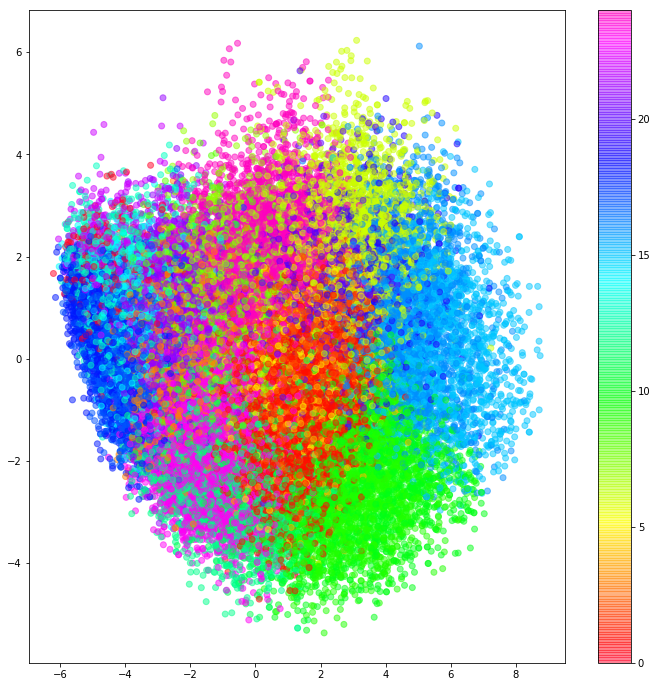

In [37]:
plt.figure(3,figsize=(12,12)) 
plt.scatter(voters_features_pca[:, 0], voters_features_pca[:, 1], c=voter_party_label, cmap='gist_rainbow', alpha=0.5);
plt.colorbar()
plt.show()

### 3.2.3 LDA candidates

In order to explore if using LDA with the party labels of the candidates will use a better base for the separation of the parties in the survey answer space we have also applied LDA to explore this option

In [38]:
can_party_label = preprocessing.LabelEncoder().fit_transform(can_labels_true)
features_lda = LDA(n_components=2).fit_transform(can_answers, can_party_label)
features_lda

array([[ 0.70712369, -3.01102173],
       [-0.1712536 ,  0.34771662],
       [ 2.80146147, -0.29483498],
       ..., 
       [ 0.07704032,  2.13979459],
       [ 0.41963926,  1.85342128],
       [ 2.62100785,  1.68953185]])

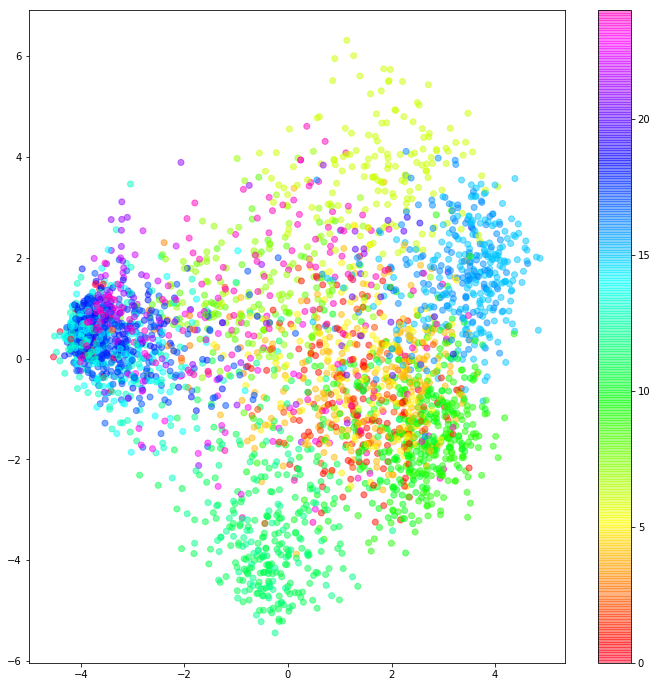

In [39]:
plt.figure(3,figsize=(12,12)) 
plt.scatter(features_lda[:, 0], features_lda[:, 1], c=can_party_label, cmap='gist_rainbow', alpha=0.5);
plt.colorbar()
plt.show()

We found that the base found by this method was very similar to the regular PCA and have therefore decided to continue our calculation using the PCA basis

## 3.3 Clustering methods

In order to create a two dimensional map of the political landscape our goal was to segment the data in a way to find potential dense spots that would justify a location for a political party in the data. The clustering methods are applied on the reduced dimensional space received from the PCA applied before, since especially the DBSCAN clustering algorithm performs poorly on high-dimensional data

Initially we want to plot both the candidate and the voter dataset without any cluster labeling and therefore visual bias and observe the datapoints in the two following scatter plots

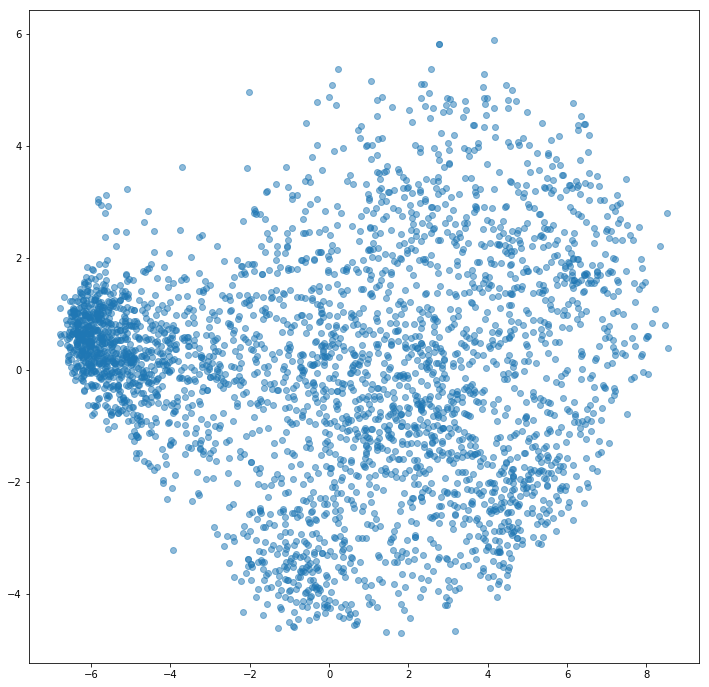

In [40]:
plt.figure(3,figsize=(12,12)) 
plt.scatter(candidate_features_pca[:, 0], candidate_features_pca[:, 1], alpha=0.5);
plt.show()

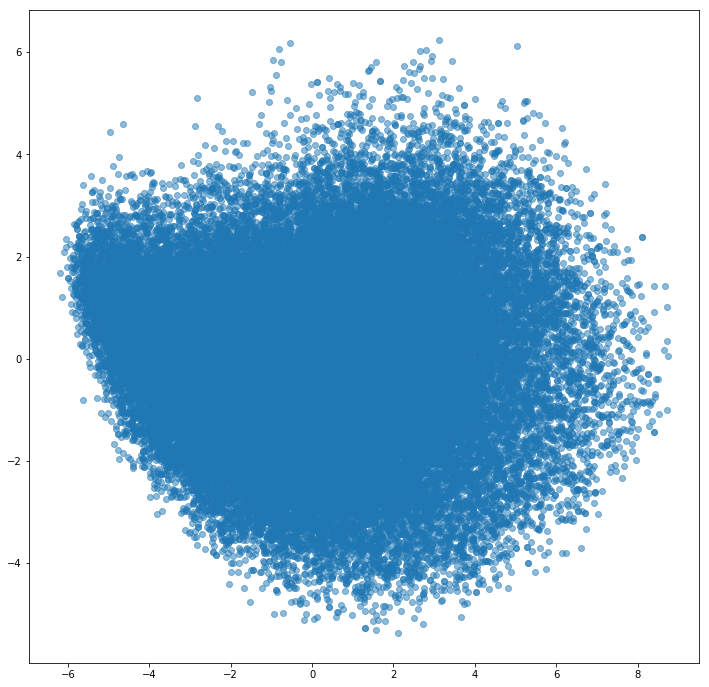

In [41]:
plt.figure(3,figsize=(12,12)) 
plt.scatter(voters_features_pca[:, 0], voters_features_pca[:, 1], alpha=0.5);
plt.show()

### 3.3.1 DBSCAN candidates

DBSCAN was our first choice since we expected it to work well on the density of the data. We have tried this approach first on the candidate data set

In [42]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

In [43]:
X = candidate_features_pca[:,:2]
DB_labels = DBSCAN(eps=0.5, min_samples=35).fit_predict(X)
np.unique(DB_labels)

array([-1,  0,  1,  2,  3,  4])

We have tried many different combinations of DBSCAN parameters, i.e. eps and sample_size and have verified the result with the plots below. We have found the above parameters to work best which resulted in DBSCAN finding five independed clusters. These clusters we have then compared below in a histogram to check how many data points actually got assigned to each cluster

(array([ 1321.,     0.,   589.,     0.,   925.,     0.,   208.,     0.,
          153.,    79.]),
 array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ]),
 <a list of 10 Patch objects>)

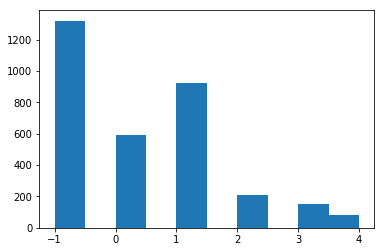

In [44]:
plt.hist(DB_labels)

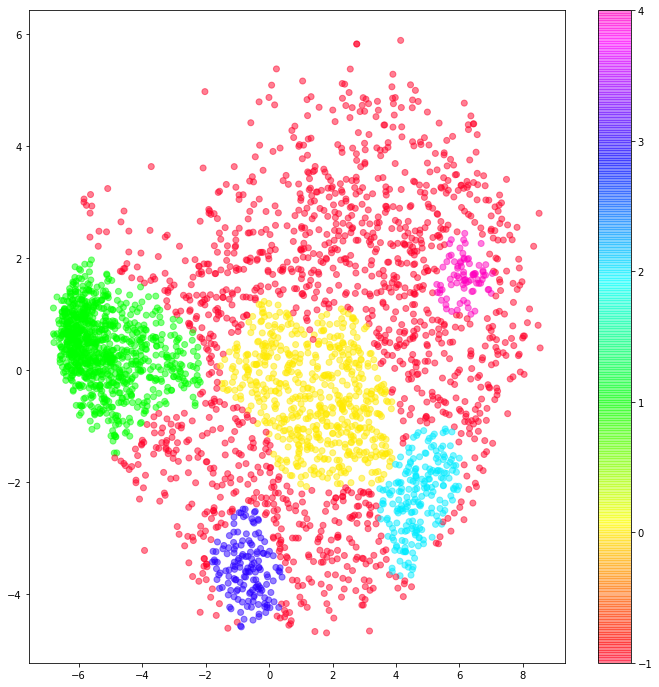

In [45]:
plt.figure(3,figsize=(12,12)) 
plt.scatter(candidate_features_pca[:, 0], candidate_features_pca[:, 1], c=DB_labels, cmap='gist_rainbow', alpha=0.5);
plt.colorbar()
plt.show()

As we can see the five clusters received were not very satisfying which many points in red which are the points that were considered noisy by the DBSCAN algorithm and hence didn't belong to any cluster found.

### 3.3.2 K-Means candidates

An obvious clustering approach was k-means, which we didn't expect to perform very well on the data since we were more looking for density related clusters. Nevertheless we have performed it also on the candidate dataset below

In [46]:
labels_kmeans = KMeans(n_clusters=10, random_state=0).fit_predict(X)

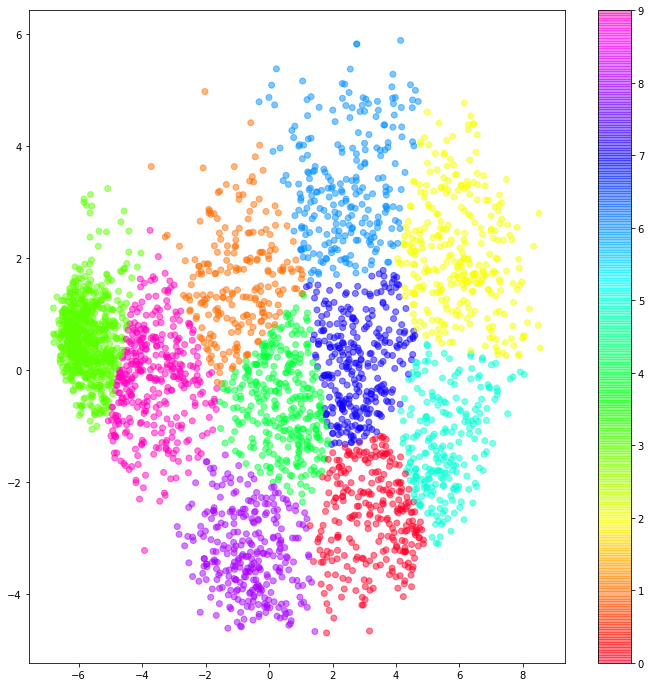

In [47]:
plt.figure(3,figsize=(12,12)) 
plt.scatter(candidate_features_pca[:, 0], candidate_features_pca[:, 1], c=labels_kmeans, cmap='gist_rainbow', alpha=0.5);
plt.colorbar()
plt.show()

As expected k-means did the non-deterministic spatial separation that initially looks better than DBSCAN but doesn't actually consider the density related properties and in many areas simply cuts dense populations apart.

### 3.3.3 DBSCAN voters

Since DBSCAN was still our main approach we continued to apply it to the voters data set to see how it would perform  on a significantly bigger dataset. Which was ultimately also the dataset of interest to be clustered.

In [48]:
from sklearn.cluster import DBSCAN, KMeans
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

In [49]:
X = voters_features_pca[:,:2]
voters_labels = DBSCAN(eps=0.155, min_samples=33).fit_predict(X)
np.unique(voters_labels)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

(array([  6.52210000e+04,   1.49000000e+02,   1.76000000e+02,
          8.30000000e+01,   5.00000000e+01,   3.90000000e+01,
          7.80000000e+01,   1.10000000e+01,   4.00000000e+00,
          6.40000000e+01]),
 array([ -1. ,   0.3,   1.6,   2.9,   4.2,   5.5,   6.8,   8.1,   9.4,
         10.7,  12. ]),
 <a list of 10 Patch objects>)

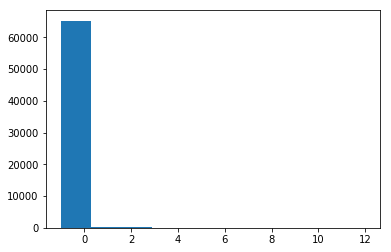

In [50]:
plt.hist(voters_labels)

Already from the histogram we could tell that there will be one major cluster and a few insignificantly small side clusters

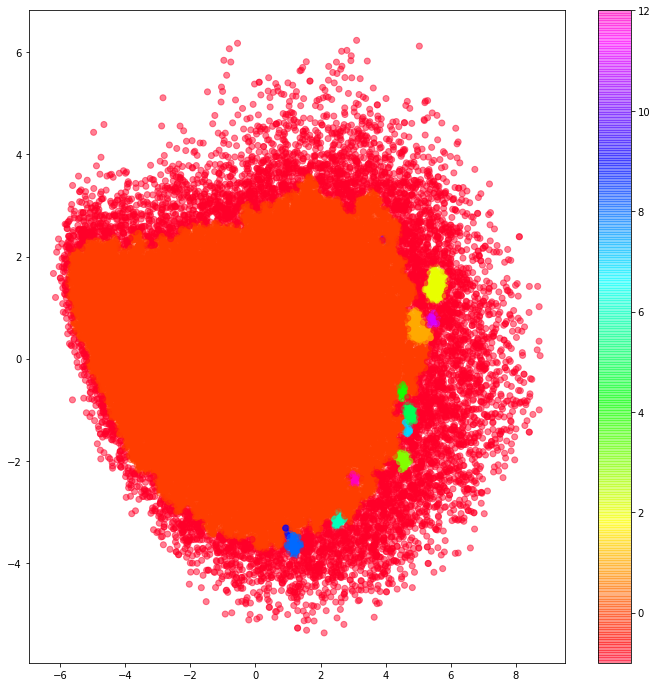

In [51]:
plt.figure(3,figsize=(12,12)) 
plt.scatter(voters_features_pca[:, 0], voters_features_pca[:, 1], c=voters_labels, cmap='gist_rainbow', alpha=0.5);
plt.colorbar()
plt.show()

Also here we have tried many different DBSCAN parameters in the hope to separate the data points in a significant manner. However it seems that the way the data is dispersed in space presented also here expected difficulties to the algorithm to successfully extract meaningful groups from the data.

### 3.3.4 K-Means voters

In [52]:
labels_kmeans = KMeans(n_clusters=10, random_state=0).fit_predict(X)

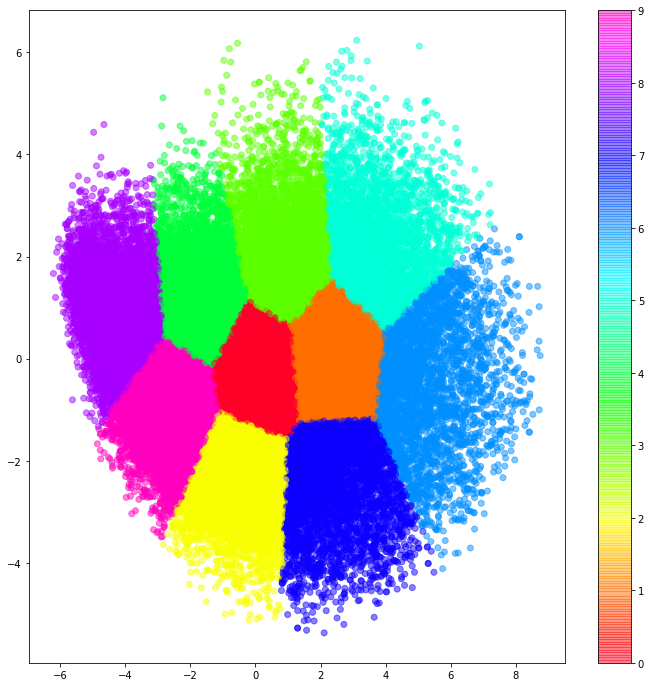

In [53]:
plt.figure(3,figsize=(12,12)) 
plt.scatter(voters_features_pca[:, 0], voters_features_pca[:, 1], c=labels_kmeans, cmap='gist_rainbow', alpha=0.5);
plt.colorbar()
plt.show()

Also here the k-means performed in extracting no meaningful clusters but rather applied the clean cut separation already seen above in the candidate dataset

### 3.3.5 GMM candidates

Further we tried Gaussian Mixture Models (GMM) in order to separate the data. We initially applied it in an unsupervised manner and only to the candidate dataset as shown below. For this we first built a colormap and a plotting function

In [54]:
from sklearn import mixture
import itertools
from scipy import linalg
import matplotlib as mpl

color_iter = itertools.cycle(['navy', 'c', 'cornflowerblue', 'gold', 'darkorange', 'magenta', 'khaki', 'firebrick',
                              'mediumpurple', 'greenyellow', 'skyblue', 'dodgerblue', 'forestgreen', 'sandybrown',
                              'silver', 'peachpuff', 'maroon', 'tomato', 'orange'])

def plot_results(X, Y_, means, covariances, index, title):
    plt.figure(3,figsize=(16,28)) 

    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(
            means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])

        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        # Plot an ellipse to show the Gaussian component
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xticks(())
    plt.yticks(())
    plt.title(title)
    

We then attempted to cluster with GMM to 25 components corresponding to the number of parties we separated already above

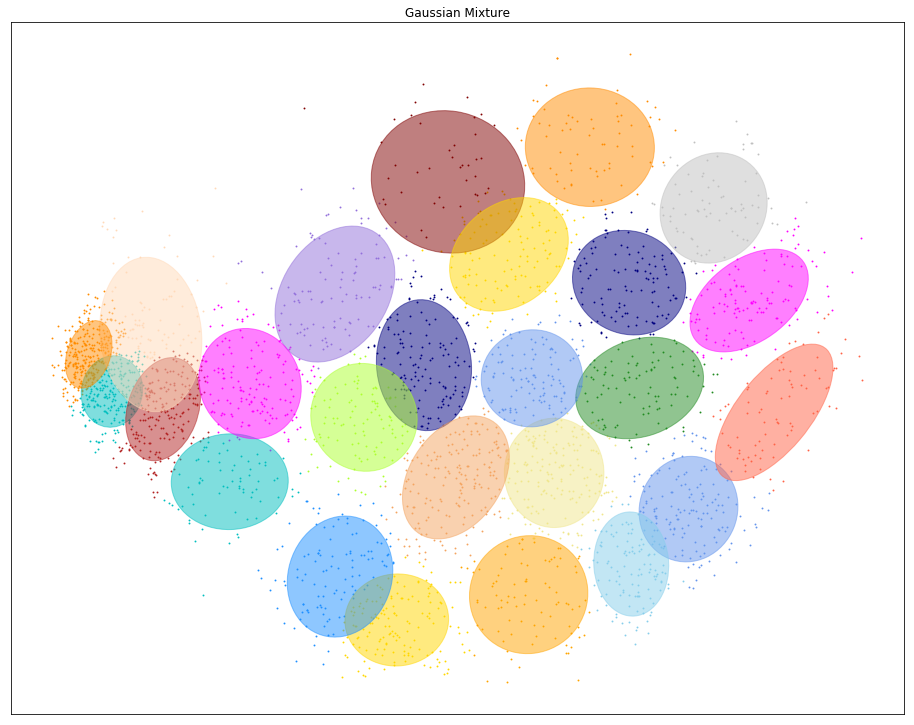

In [55]:
# Fit the Gaussian mixture with EM in 2 dimension of the PCA

X = candidate_features_pca[:,:2]
gmm = mixture.GaussianMixture(n_components=25, covariance_type='full').fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0, 'Gaussian Mixture')

Using more than 2 dimensions of the PCA will result in the GMM clusters to narrow significantly as can be seen by the covariance ellipses below

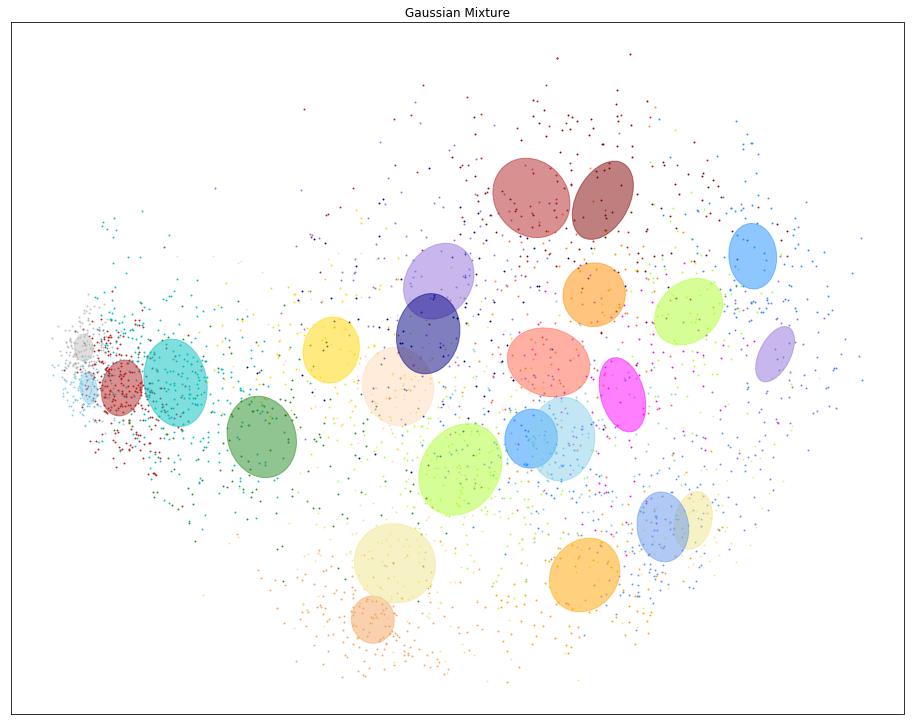

In [56]:
# Fit the Gaussian mixture with EM in 10-dimension of the PCA

X = candidate_features_pca[:,:10]
gmm = mixture.GaussianMixture(n_components=25, covariance_type='full').fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0, 'Gaussian Mixture')

Intuitively from the data without labels above we found that 5 clusters would be a reasonable partitioning to expect from the candidate dataset and therefore have run the GMM again with only 5 components below

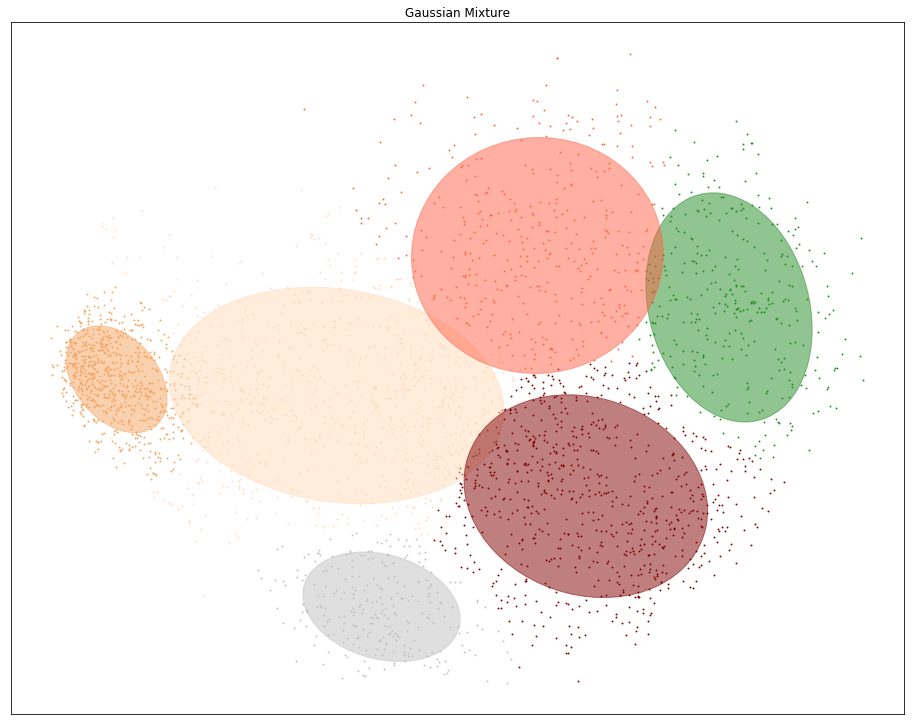

In [57]:
# Fit the Gaussian mixture with EM in 2 dimension of the PCA with only 5 componnents

X = candidate_features_pca[:,:2]
gmm = mixture.GaussianMixture(n_components=6, covariance_type='full').fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0, 'Gaussian Mixture')

Thereafter we were interested to identify the party centroids we have extracted from the candidate dataset further above to see where the corresponding parties would fall in those clusters. For this we modified the plotting function to include those centroids and show the corresponding party label

In [58]:
candidate_features_pca.shape

(3275, 75)

In [59]:
mapped_can_centroids = candidate_pca.transform(can_party_centroids)

In [60]:
def centroid_plot_results(X, Y_, means, covariances, index, title):
    fig = plt.figure(3,figsize=(16,28)) 

    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])

        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    z = mapped_can_centroids[:,0]
    y = mapped_can_centroids[:,1]
    splot.scatter(z, y, 50, color='black')

    for i in range(25):
        splot.annotate(parties[i], (z[i],y[i]))

    plt.xticks(())
    plt.yticks(())
    plt.title(title)

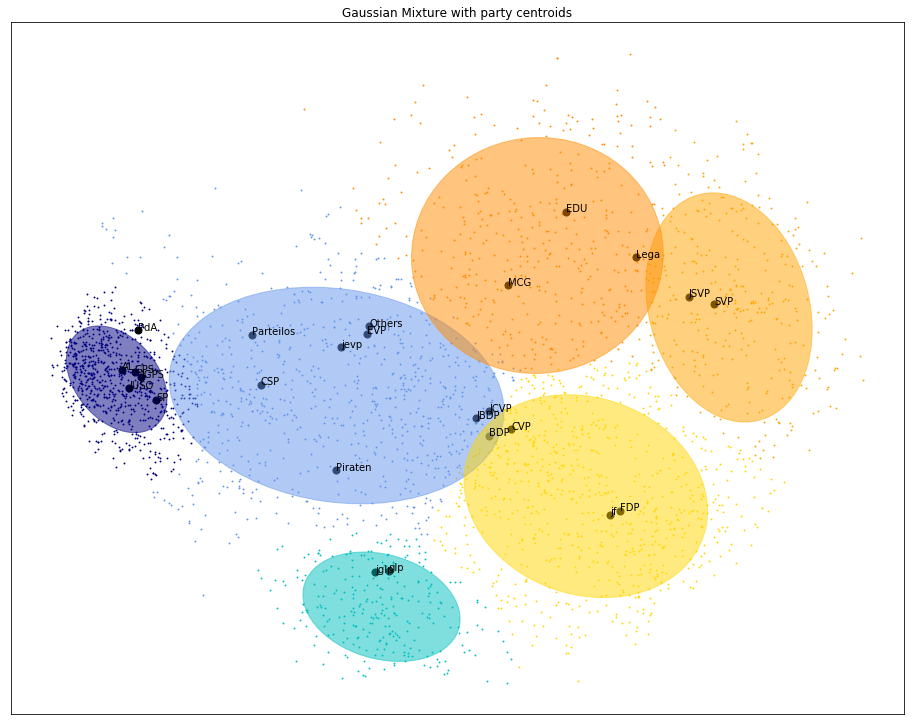

In [61]:
centroid_plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0, 'Gaussian Mixture with party centroids')

### 3.3.6 GMM voters

Consequtively we applied the same GMM procedure to the voters dataset. Initially trying to cluster the voters in just two separate parties

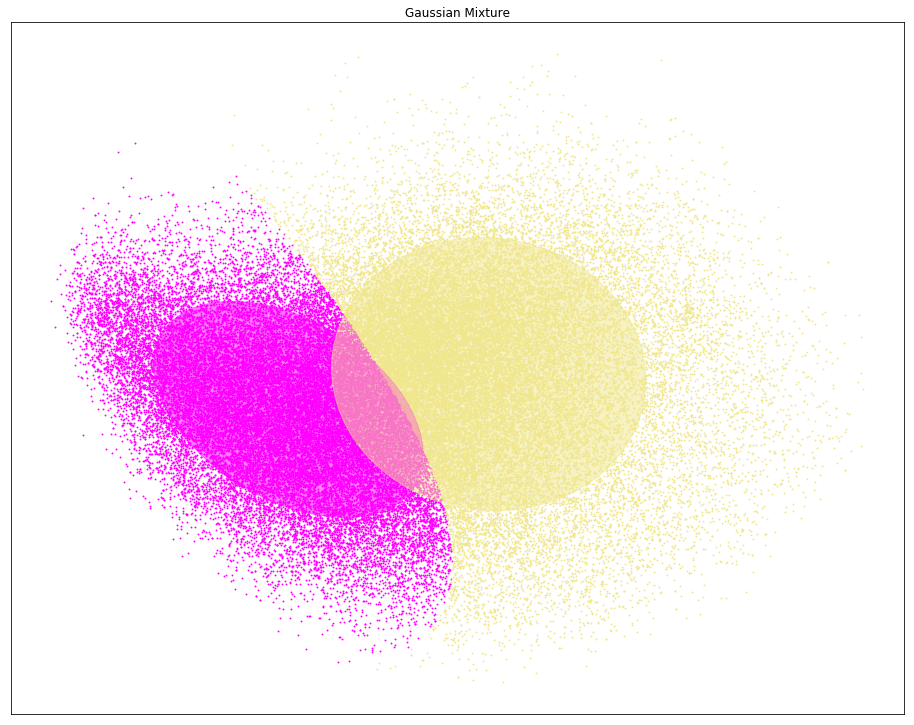

In [62]:
X = voters_features_pca[:,:2]

# Fit a Gaussian mixture with EM using 2 components
gmm = mixture.GaussianMixture(n_components=2, covariance_type='full').fit(X)
plot_results(X, gmm.predict(X), gmm.means_, gmm.covariances_, 0, 'Gaussian Mixture')

Seen from the location of the parties above one could even identify the left part to be left wing and the right cluster to be right wing in this picture

# Supervised GMM candidates

We then continued with a supervised approach, where we used the candidate dataset with defined party allocations as training labels for a supervised GMM training as seen below

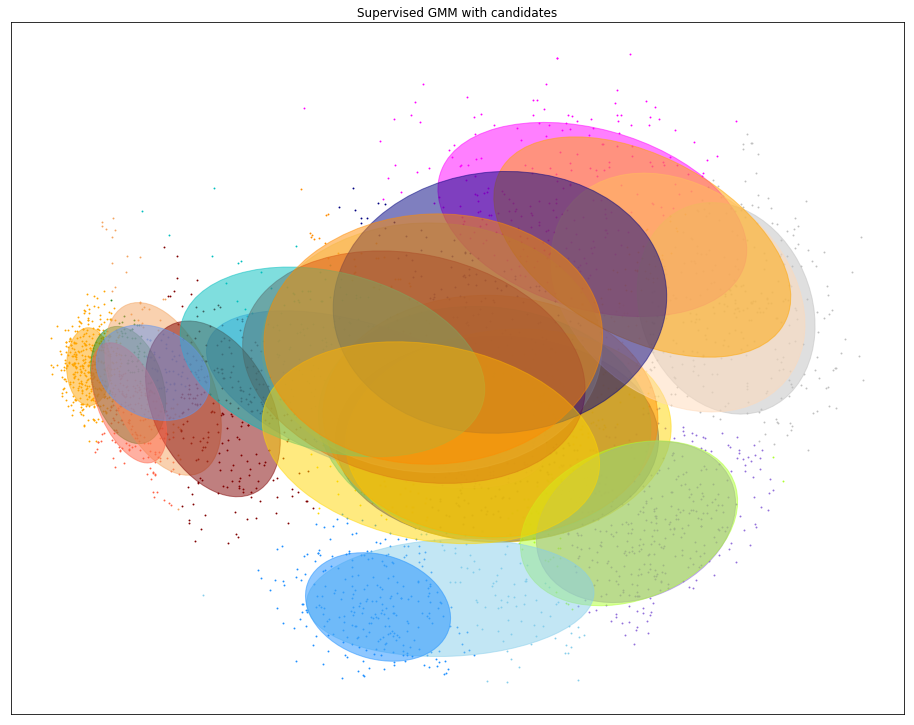

In [73]:
from sklearn.mixture import GMM

X_train = candidate_features_pca[:,:2]
X = candidate_features_pca[:,:2]

y_train = can_labels_true
n_classes = len(np.unique(y_train))

gmm = GMM(n_components=n_classes, covariance_type='full', init_params='wc', n_iter=20)

gmm.means_ = np.array([X_train[y_train == i].mean(axis=0) for i in range(n_classes)])

gmm.fit(X)

plot_results(X, gmm.predict(X), gmm.means_, gmm.covars_, 0, 'Supervised GMM with candidates')

In [74]:
mapped_can_centroids = candidate_pca.transform(can_party_centroids)

In [75]:
def color_centroid_plot_results(X, Y_, means, covariances, index, title):
    fig = plt.figure(3,figsize=(16,28)) 
    
    z = mapped_can_centroids[:,0]
    y = mapped_can_centroids[:,1]
    
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])

        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)
        
        plt.plot(z[i], y[i], marker='o', markersize=10, color=color)
        splot.annotate(parties[i], (z[i],y[i]), color='black')

    plt.xticks(())
    plt.yticks(())
    plt.title(title)

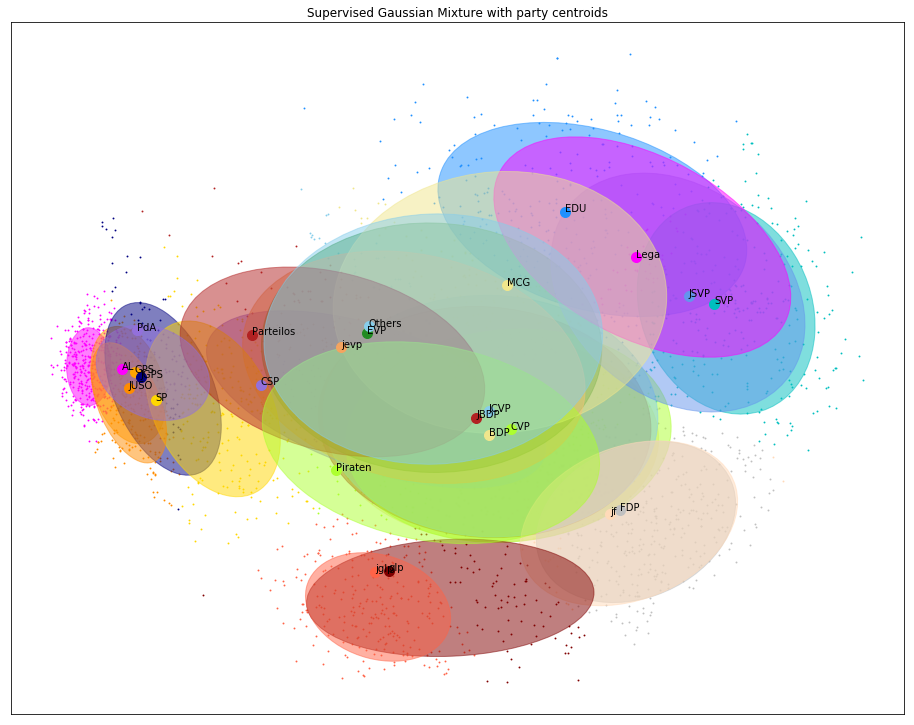

In [76]:
color_centroid_plot_results(X, gmm.predict(X), gmm.means_, gmm.covars_, 0, 'Supervised Gaussian Mixture with party centroids')

# Supervised GMM voters

This trained GMM model we then used to predict the party labels of the voters as can be seen below

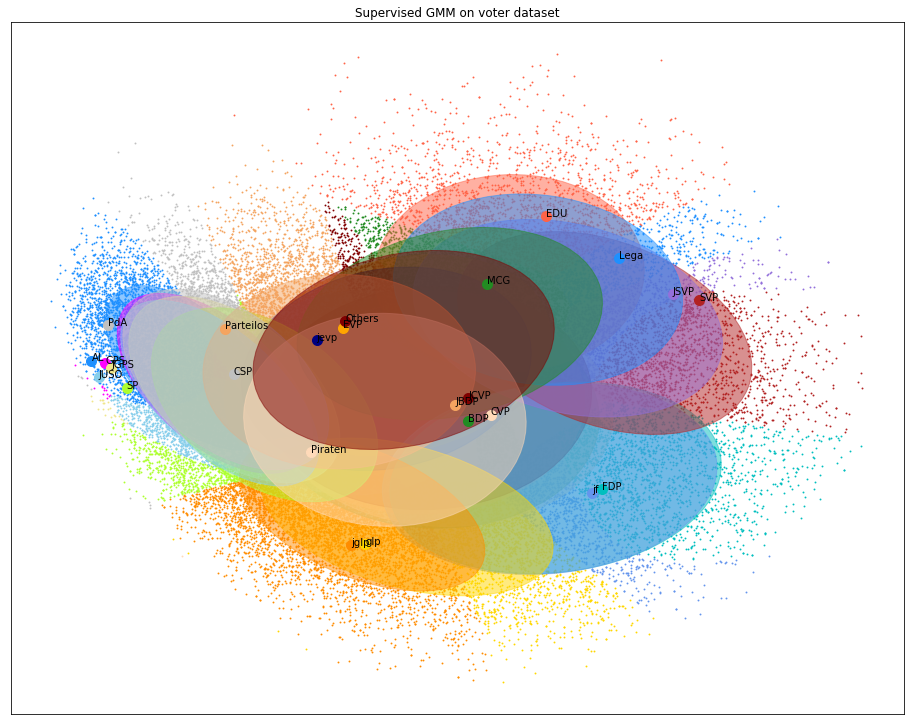

In [77]:
X = voters_features_pca[:,:2]

gmm.fit(X)

color_centroid_plot_results(X, gmm.predict(X), gmm.means_, gmm.covars_, 0, 'Supervised GMM on voter dataset')

In order to better see the different clusters we have then removed the ellipses from the plotting function

In [78]:
def no_ellipse_plot_results(X, Y_, means, covariances, index, title):
    fig = plt.figure(3,figsize=(16,28)) 
    
    z = mapped_can_centroids[:,0]
    y = mapped_can_centroids[:,1]
    
    splot = plt.subplot(2, 1, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])

        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)
        plt.plot(z[i], y[i], marker='o', markersize=10, color=color)
        splot.annotate(parties[i], (z[i],y[i]), color='black')
        
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

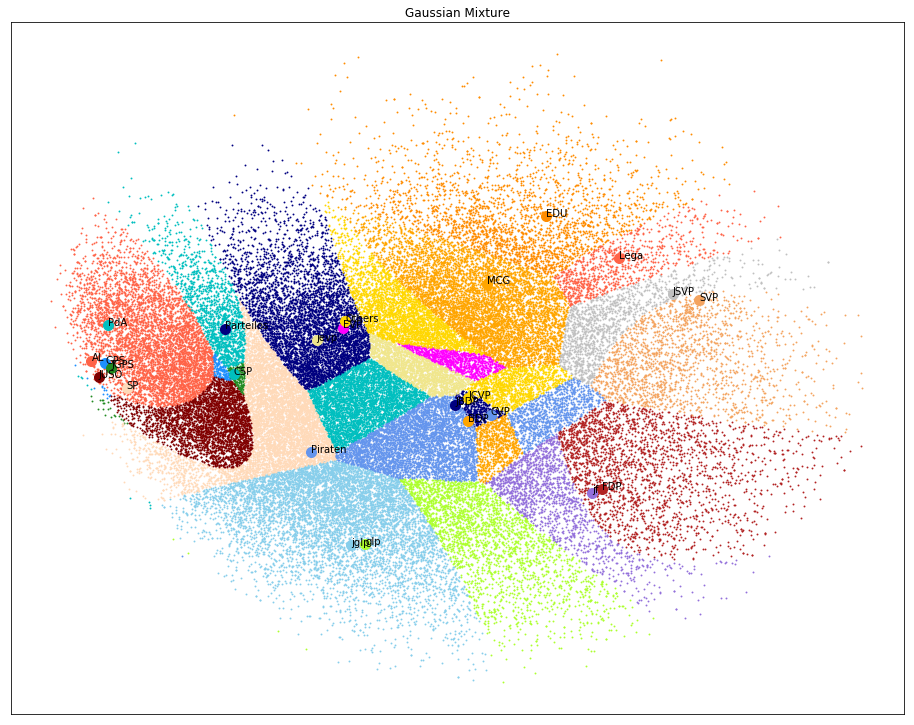

In [79]:
no_ellipse_plot_results(X, gmm.predict(X), gmm.means_, gmm.covars_, 0, 'Gaussian Mixture')

The clusters above are the assidgned political party found for the individual voters by the GMM model trained on the candidate data.

In [80]:
(data['recommendation'] == gmm.predict(X)).value_counts()

False    54502
True     11373
Name: recommendation, dtype: int64

As mentionned at the beginning, we don't have a ground truth and thus we can't really say if those new assigned parties are accurate or not. We can only say that they are different from the recommendations made by SmartVote and our first recommendations.

# 4 Conclusions
### 4.1 Graph based analysis
To summarize the graph built from the cantons managed to visualize the Röstigraben. We could successfuly group left/right and liberal/conserative parties without any supervision by building political party graphs. The party neighbour comparison also showed that very similar party recommendations could be achieved from our cosine distance based metric as the one from smartvote.

### 4.2. Extended PCA based analysis
While the candidates could be clustered with reasonable satisfiability using PCA and LDA, this could not be replicated for the voter dataset.
DBscan which considers point densities for clustering was attempted as second approach, but no good results could be achieved. Next K-means clustering was used with little hope, because the cluster separation didn't take into account the sample densities. And as expected, no meaningful clusters could be extracted by K-mean analysis. As a final apporach, we decided to use GMM for clustering, which performed reasonably well on the candidate dataset, but required to define the number of clusters to separate and we failed to achieve similar results for the voter dataset.
This seemingly easier separability of the candidates in comparison to the voter dataset can be interpreted by the hypothesis that polititcal candidates can be subject to a bias in their opinions towards positions that their affiliated party requires them to represent. This can lead to better defined clusters that are not present in voter opinions, because the distribution of voter opinions will be more uniformly distributed and thus less easily separable.